/kaggle/  
├── input/  
│   └── cifar-10-batches-bin/  
│       ├── data_batch_1.bin  
│       ├── data_batch_2.bin  
│       ├── data_batch_3.bin  
│       ├── data_batch_4.bin  
│       ├── data_batch_5.bin  
│       └── test_batch.bin  
├── working/  
│   └──**this notebook**


In [45]:
import cupy as cp

In [ ]:
class ResidualBlock:
    def __init__(self, in_channels, out_channels, stride=1, use_adam=True):
        self.stride = stride
        self.use_adam = use_adam

        self.conv1 = Conv2D(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, use_adam=use_adam)
        self.bn1 = BatchNorm2D(out_channels)

        self.conv2 = Conv2D(out_channels, out_channels, kernel_size=3, stride=1, padding=1, use_adam=use_adam)
        self.bn2 = BatchNorm2D(out_channels)

        if in_channels != out_channels or stride != 1:
            self.downsample = Conv2D(in_channels, out_channels, kernel_size=1, stride=stride, padding=0, use_adam=use_adam)
            self.bn_down = BatchNorm2D(out_channels)
        else:
            self.downsample = None

    def forward(self, x, training=True):
        self.x = x # 保存输入用于反向传播

        # 主路径第一层
        out = self.conv1.forward(x)
        out = self.bn1.forward(out, training)
        self.out1_relu = cp.maximum(out, 0) # ReLU激活

        # 主路径第二层
        out = self.conv2.forward(self.out1_relu)
        out = self.bn2.forward(out, training)

        # 捷径路径：如果维度不匹配则使用1x1卷积调整
        if self.downsample is not None:
            self.shortcut = self.bn_down.forward(self.downsample.forward(x), training)
        else:
            self.shortcut = x

        # 残差连接：主路径输出 + 捷径路径
        self.out = out + self.shortcut
        self.out_relu = cp.maximum(self.out, 0)

        # 累计 L2 正则项
        self.l2_loss = 0.0
        for layer in [self.conv1, self.conv2, self.bn1, self.bn2]:
            self.l2_loss += getattr(layer, "l2_loss", 0.0)
        if self.downsample is not None:
            self.l2_loss += getattr(self.downsample, "l2_loss", 0.0)
            self.l2_loss += getattr(self.bn_down, "l2_loss", 0.0)

        return self.out_relu

    def backward(self, grad_output):
        grad = grad_output * (self.out > 0)

        grad_bn2 = self.bn2.backward(grad)
        grad_conv2 = self.conv2.backward(grad_bn2)

        grad_relu1 = grad_conv2 * (self.out1_relu > 0)
        grad_bn1 = self.bn1.backward(grad_relu1)
        grad_conv1 = self.conv1.backward(grad_bn1)

        # shortcut 分支使用保存的 self.shortcut 来反向传播
        if self.downsample is not None:
            grad_shortcut = self.downsample.backward(self.bn_down.backward(grad))
        else:
            grad_shortcut = grad

        return grad_conv1 + grad_shortcut


In [ ]:
class BatchNorm2D:
    def __init__(self, num_channels, momentum=0.9, eps=1e-5):
        self.gamma = cp.ones((1, num_channels, 1, 1))
        self.beta = cp.zeros((1, num_channels, 1, 1))
        self.momentum = momentum
        self.eps = eps
        self.running_mean = cp.zeros((1, num_channels, 1, 1))
        self.running_var = cp.ones((1, num_channels, 1, 1))

        self.opt_gamma = AdamOptimizer(self.gamma.shape)
        self.opt_beta = AdamOptimizer(self.beta.shape)

    def forward(self, x, training=True):
        self.x = x
        if training:
            mean = cp.mean(x, axis=(0, 2, 3), keepdims=True)
            var = cp.var(x, axis=(0, 2, 3), keepdims=True)

            self.normalized = (x - mean) / cp.sqrt(var + self.eps)
            out = self.gamma * self.normalized + self.beta

            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * var

            self.mean, self.var = mean, var
        else:
            normalized = (x - self.running_mean) / cp.sqrt(self.running_var + self.eps)
            out = self.gamma * normalized + self.beta

        # 加入正则项
        self.l2_loss = cp.sum(self.gamma ** 2) + cp.sum(self.beta ** 2)

        return out

    def backward(self, dout):
        N, C, H, W = dout.shape

        x_mu = self.x - self.mean
        std_inv = 1. / cp.sqrt(self.var + self.eps)

        dgamma = cp.sum(dout * self.normalized, axis=(0, 2, 3), keepdims=True)
        dbeta = cp.sum(dout, axis=(0, 2, 3), keepdims=True)

        dnorm = dout * self.gamma
        dvar = cp.sum(dnorm * x_mu, axis=(0,2,3), keepdims=True) * -0.5 * std_inv**3
        dmean = cp.sum(dnorm * -std_inv, axis=(0,2,3), keepdims=True) + dvar * cp.mean(-2. * x_mu, axis=(0,2,3), keepdims=True)
        dx = dnorm * std_inv + dvar * 2 * x_mu / (N*H*W) + dmean / (N*H*W)

        # 使用优化器更新参数
        self.gamma = self.opt_gamma.update(self.gamma, dgamma)
        self.beta = self.opt_beta.update(self.beta, dbeta)

        return dx


In [ ]:
class Conv2D:
    def __init__(self, input_channels, output_channels, kernel_size, stride=1, padding=0, use_adam=True):
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        # self.W = cp.random.randn(output_channels, input_channels, kernel_size, kernel_size) * 0.1
        
        # He初始化
        self.W = cp.random.randn(output_channels, input_channels, kernel_size, kernel_size) * cp.sqrt(2.0 / (input_channels * kernel_size * kernel_size))
        self.b = cp.zeros((output_channels, 1))
        self.use_adam = use_adam
        if use_adam:
            self.opt_W = AdamOptimizer(self.W.shape)
            self.opt_b = AdamOptimizer(self.b.shape)

    def forward(self, x):
        self.x = x
        N, C, H, W = x.shape
        K = self.kernel_size
        S = self.stride
        P = self.padding

        x_padded = cp.pad(x, ((0,0), (0,0), (P,P), (P,P)))
        x_windows = cp.lib.stride_tricks.sliding_window_view(x_padded, (K, K), axis=(2, 3))
        x_windows = x_windows[:, :, ::S, ::S, :, :]
        N, C, H_out, W_out, KH, KW = x_windows.shape

        x_col = x_windows.transpose(0, 2, 3, 1, 4, 5).reshape(-1, C * K * K)
        W_col = self.W.reshape(self.output_channels, -1)

        out = x_col @ W_col.T + self.b.T
        out = out.reshape(N, H_out, W_out, self.output_channels).transpose(0, 3, 1, 2)
        self.x_col = x_col
        self.x_windows_shape = (N, C, H_out, W_out, K, K)

        # L2正则项 每次 forward 自动更新
        self.l2_loss = cp.sum(self.W ** 2) + cp.sum(self.b ** 2)

        return out

    def backward(self, dout, learning_rate=0.01, reg_lambda=1e-4):
        N, C_out, H_out, W_out = dout.shape
        K = self.kernel_size
        x_col = self.x_col
        dout_reshaped = dout.transpose(0, 2, 3, 1).reshape(-1, C_out)
        dW = dout_reshaped.T @ x_col
        dW = dW.reshape(self.W.shape)
        db = cp.sum(dout_reshaped, axis=0, keepdims=True).T
        W_col = self.W.reshape(C_out, -1)
        dx_col = dout_reshaped @ W_col

        N, C, H_out, W_out, KH, KW = self.x_windows_shape
        dx_windows = dx_col.reshape(N, H_out, W_out, C, KH, KW).transpose(0, 3, 4, 5, 1, 2)
        dx = cp.zeros((N, C, H_out * self.stride + self.padding * 2, W_out * self.stride + self.padding * 2), dtype=dx_windows.dtype)

        for i in range(KH):
            for j in range(KW):
                dx[:, :, i:i + H_out * self.stride:self.stride, j:j + W_out * self.stride:self.stride] += dx_windows[:, :, i, j, :, :]

        if self.padding > 0:
            dx = dx[:, :, self.padding:-self.padding, self.padding:-self.padding]

        if self.use_adam:
            self.W = self.opt_W.update(self.W, dW + reg_lambda * self.W)
            self.b = self.opt_b.update(self.b, db)
        else:
            self.W -= learning_rate * (dW + reg_lambda * self.W)
            self.b -= learning_rate * db

        return dx


In [ ]:
class AdamOptimizer:
    def __init__(self, param_shape, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = cp.zeros(param_shape)
        self.v = cp.zeros(param_shape)
        self.t = 0

    def update(self, param, grad):
        # 更新时间步
        self.t += 1
        self.m = self.beta1 * self.m + (1 - self.beta1) * grad # 更新一阶矩估计
        self.v = self.beta2 * self.v + (1 - self.beta2) * (grad ** 2) # 更新二阶矩估计
        # 计算偏差校正后的估计
        m_hat = self.m / (1 - self.beta1 ** self.t)
        v_hat = self.v / (1 - self.beta2 ** self.t)
        
        update = self.lr * m_hat / (cp.sqrt(v_hat) + self.eps)
        return param - update

In [50]:
# 最大池化
class MaxPool2D:
    def __init__(self, kernel_size=2, stride=2): 
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, x):
        self.x = x # 反向传播需要所以先保留一下
        N, C, H, W = x.shape
        KH, KW = self.kernel_size, self.kernel_size
        SH, SW = self.stride, self.stride

        H_out = (H - KH) // SH + 1
        W_out = (W - KW) // SW + 1

        x_reshaped = x.reshape(N, C, H_out, KH, W_out, KW)
        x_reshaped = x_reshaped.transpose(0, 1, 2, 4, 3, 5).reshape(N, C, H_out, W_out, -1)

        self.argmax = cp.argmax(x_reshaped, axis=-1)
        self.x_reshaped = x_reshaped
        return cp.max(x_reshaped, axis=-1)

    def backward(self, dout):
        N, C, H_out, W_out = dout.shape
        KH, KW = self.kernel_size, self.kernel_size

        dx_flat = cp.zeros_like(self.x_reshaped) # 接收梯度
        flat_idx = self.argmax.flatten()
        dout_flat = dout.flatten()
         # 将 dout 仅分配给最大值位置，其它为 0
        dx_flat = dx_flat.reshape(-1, dx_flat.shape[-1])
        dx_flat[cp.arange(flat_idx.shape[0]), flat_idx] = dout_flat
        dx_flat = dx_flat.reshape(self.x_reshaped.shape)
        # 恢复原始形状：[N, C, H_out, KH, W_out, KW] → [N, C, H, W]
        dx = dx_flat.reshape(N, C, H_out, KW, W_out, KH).transpose(0, 1, 2, 4, 3, 5)
        dx = dx.reshape(N, C, H_out * KH, W_out * KW)
        return dx



In [51]:
class GlobalAveragePool2D:
    def forward(self, x):
        self.x = x
        return cp.mean(x, axis=(2, 3), keepdims=False)  # shape: (N, C)

    def backward(self, dout):
        N, C = dout.shape
        H, W = self.x.shape[2], self.x.shape[3]
        return dout[:, :, None, None] * cp.ones((N, C, H, W)) / (H * W)


In [52]:
# class FullyConnected:
#     def __init__(self, input_dim, output_dim, use_adam=True):
#         # self.W = cp.random.randn(input_dim, output_dim) * 0.01
#         self.W = cp.random.randn(input_dim, output_dim) * cp.sqrt(2.0 / input_dim)  # He初始化
#         self.b = cp.zeros((1, output_dim))
#         self.l2_loss = 0.0  # 记录 L2 范数
#         self.use_adam = use_adam
#         if use_adam:
#             self.opt_W = AdamOptimizer(self.W.shape)
#             self.opt_b = AdamOptimizer(self.b.shape)

#     def forward(self, x):
#         self.x = x
#         self.l2_loss = cp.sum(self.W ** 2) + cp.sum(self.b ** 2)  # 同时加上偏置项
#         return cp.dot(x, self.W) + self.b

#     def backward(self, dout, learning_rate=0.01, reg_lambda=1e-4):
#         dx = cp.dot(dout, self.W.T)
#         dW = cp.dot(self.x.T, dout) + reg_lambda * self.W
#         db = cp.sum(dout, axis=0, keepdims=True)
#         if self.use_adam:
#             self.W = self.opt_W.update(self.W, dW)
#             self.b = self.opt_b.update(self.b, db)
#         else:
#             self.W -= learning_rate * dW
#             self.b -= learning_rate * db
#         return dx


In [53]:
# 带有dropout的FC
class FullyConnected:
    def __init__(self, input_dim, output_dim, use_adam=True, dropout_rate=0.0):
        self.W = cp.random.randn(input_dim, output_dim) * cp.sqrt(2.0 / input_dim)  # He初始化
        self.b = cp.zeros((1, output_dim))
        self.l2_loss = 0.0
        self.use_adam = use_adam
        self.dropout_rate = dropout_rate
        self.dropout_mask = None

        if use_adam:
            self.opt_W = AdamOptimizer(self.W.shape)
            self.opt_b = AdamOptimizer(self.b.shape)

    def forward(self, x, training=True):
        self.x = x
        out = cp.dot(x, self.W) + self.b
        self.l2_loss = cp.sum(self.W ** 2) + cp.sum(self.b ** 2)

        if training and self.dropout_rate > 0:
            # Dropout mask
            self.dropout_mask = (cp.random.rand(*out.shape) > self.dropout_rate).astype(out.dtype)
            out = out * self.dropout_mask / (1.0 - self.dropout_rate)  # scale
        return out

    def backward(self, dout, learning_rate=0.01, reg_lambda=1e-4):
        if self.dropout_rate > 0 and self.dropout_mask is not None:
            dout = dout * self.dropout_mask / (1.0 - self.dropout_rate)

        dx = cp.dot(dout, self.W.T)
        dW = cp.dot(self.x.T, dout) + reg_lambda * self.W
        db = cp.sum(dout, axis=0, keepdims=True)

        if self.use_adam:
            self.W = self.opt_W.update(self.W, dW)
            self.b = self.opt_b.update(self.b, db)
        else:
            self.W -= learning_rate * dW
            self.b -= learning_rate * db
        return dx


In [54]:
class ReLU:
    def __init__(self):
        self.mask = None
    def forward(self, x):
        self.mask = (x > 0)
        return x * self.mask
    def backward(self, dout):
        return dout * self.mask # 只对 x > 0 的位置反传梯度，其它为 0

class Flatten:
    def __init__(self):
        self.input_shape = None
    def forward(self, x):
        self.input_shape = x.shape
        return x.reshape(x.shape[0], -1)
    def backward(self, dout):
        return dout.reshape(self.input_shape)

class SoftmaxWithLoss:
    def __init__(self):
        self.y_pred = None
        self.y_true = None
    def forward(self, x, y_true):
        '''
        x -- 表示每个样本的 logit
        y_true -- one-hot 标签
        '''
        # 防止指数爆炸
        x = x - cp.max(x, axis=1, keepdims=True)
        exp = cp.exp(x)
        
        self.y_pred = exp / cp.sum(exp, axis=1, keepdims=True)
        self.y_true = y_true
        loss = -cp.sum(y_true * cp.log(self.y_pred + 1e-8)) / x.shape[0]
        acc = cp.mean(cp.argmax(self.y_pred, axis=1) == cp.argmax(y_true, axis=1))
        return loss, acc
    def backward(self):
        return (self.y_pred - self.y_true) / self.y_true.shape[0]


In [55]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


### CNN
Conv2D → ReLU → MaxPool  
Conv2D → ReLU → MaxPool  
Flatten → FC(512) → ReLU → (Dropout not yet) → FC(10) → Softmax  


In [ ]:
# class SimpleCNN:
#     def __init__(self):
#         self.conv1 = Conv2D(3, 32, 3, padding=1)     # (3, 32, 32) → (32, 32, 32)
#         self.relu1 = ReLU()
#         self.pool1 = MaxPool2D(2, 2)                 # → (32, 16, 16)

#         self.conv2 = Conv2D(32, 64, 3, padding=1)    # → (64, 16, 16)
#         self.relu2 = ReLU()
#         self.pool2 = MaxPool2D(2, 2)                 # → (64, 8, 8)

#         self.flatten = Flatten()                    # → 64×8×8 = 4096
#         self.fc1 = FullyConnected(64 * 8 * 8, 512)
#         self.relu3 = ReLU()
#         self.fc2 = FullyConnected(512, 10)
#         self.softmax_loss = SoftmaxWithLoss()

#     def forward(self, x, y):
#         out = self.conv1.forward(x)
#         out = self.relu1.forward(out)
#         out = self.pool1.forward(out)

#         out = self.conv2.forward(out)
#         out = self.relu2.forward(out)
#         out = self.pool2.forward(out)

#         out = self.flatten.forward(out)
#         out = self.fc1.forward(out)
#         out = self.relu3.forward(out)
#         # out = self.dropout.forward(out, train=True)
#         out = self.fc2.forward(out)
#         loss, acc = self.softmax_loss.forward(out, y)
#         return loss, acc

#     def backward(self, learning_rate=0.01):
#         dout = self.softmax_loss.backward()
#         dout = self.fc2.backward(dout, learning_rate)
#         # dout = self.dropout.backward(dout)
#         dout = self.relu3.backward(dout)
#         dout = self.fc1.backward(dout, learning_rate)
#         dout = self.flatten.backward(dout)
#         dout = self.pool2.backward(dout)
#         dout = self.relu2.backward(dout)
#         dout = self.conv2.backward(dout, learning_rate)
#         dout = self.pool1.backward(dout)
#         dout = self.relu1.backward(dout)
#         dout = self.conv1.backward(dout, learning_rate)

#     def predict(self, x):
#         out = self.conv1.forward(x)
#         out = self.relu1.forward(out)
#         out = self.pool1.forward(out)

#         out = self.conv2.forward(out)
#         out = self.relu2.forward(out)
#         out = self.pool2.forward(out)

#         out = self.flatten.forward(out)
#         out = self.fc1.forward(out)
#         out = self.relu3.forward(out)
#         # out = self.dropout.forward(out, train=False)
#         out = self.fc2.forward(out)
#         return cp.argmax(out, axis=1)


In [35]:
# from tqdm.notebook import tqdm

# def evaluate_on_val(model, X_val, Y_val, batch=64):
#     total_loss, correct = 0.0, 0
#     for i in range(0, X_val.shape[0], batch):
#         xb = X_val[i:i+batch]
#         yb = Y_val[i:i+batch]
#         loss, acc = model.forward(xb, yb)
#         pred = model.predict(xb)
#         total_loss += loss * xb.shape[0]
#         correct += cp.sum(pred == cp.argmax(yb, axis=1))
#     return total_loss / X_val.shape[0], correct / X_val.shape[0]

# def train_CNN(model, X, Y, X_val=None, Y_val=None, epochs=10, batch=64, lr=0.01, reg_lambda=1e-4):
#     stopper = EarlyStopping(patience=5)
#     best_val_loss = float('inf')

#     for epoch in range(epochs):
#         idx = cp.random.permutation(X.shape[0])
#         X, Y = X[idx], Y[idx]
#         total_loss, correct = 0.0, 0

#         with tqdm(total=X.shape[0], desc=f"Epoch {epoch+1}/{epochs}", unit="sample") as pbar:
#             for i in range(0, X.shape[0], batch):
#                 xb = X[i:i+batch]
#                 yb = Y[i:i+batch]

#                 # Forward + reg loss
#                 loss, acc = model.forward(xb, yb)
#                 reg_loss = sum(layer.l2_loss for layer in model.__dict__.values() if hasattr(layer, 'l2_loss'))
#                 loss += reg_lambda * reg_loss

#                 model.backward(learning_rate=lr)
#                 pred = model.predict(xb)
#                 correct += cp.sum(pred == cp.argmax(yb, axis=1))
#                 total_loss += loss * xb.shape[0]

#                 pbar.update(xb.shape[0])
#                 pbar.set_postfix(loss=float(loss), acc=float(acc))

#         avg_loss = total_loss / X.shape[0]
#         train_acc = correct / X.shape[0]
#         print(f"Epoch {epoch+1} Summary: Loss {avg_loss:.4f}, Accuracy {train_acc:.4f}")

#         if X_val is not None and Y_val is not None:
#             val_loss, val_acc = evaluate_on_val(model, X_val, Y_val)
#             stopper(val_loss)
#             print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, Stop Counter: {stopper.counter}")

#             # 自动学习率衰减逻辑
#             if val_loss >= best_val_loss:
#                 lr *= 0.5
#                 print(f"No improvement in val_loss. Reducing learning rate to {lr:.6f}")
#             else:
#                 best_val_loss = val_loss

#             if stopper.early_stop:
#                 print("Early stopping triggered.")
#                 break


### RESNET
Input: (3, 32, 32)  

Conv2D(3 → 64, 3x3) → BN → ReLU  
layer1 (2× ResidualBlock(64 → 64))  
layer2 (2× ResidualBlock(64 → 128))  
layer3 (2× ResidualBlock(128 → 256))  
layer4 (2× ResidualBlock(256 → 512))  
GlobalAveragePool2D → FullyConnected(512 → 10)  

In [56]:
class ResNet:
    def __init__(self, block_config=[2, 2, 2, 2], num_classes=10, use_adam=True):
        self.use_adam = use_adam
        self.in_channels = 64  # 初始通道数

        # 初始卷积层
        self.conv1 = Conv2D(3, 64, kernel_size=3, stride=1, padding=1, use_adam=use_adam)
        self.bn1 = BatchNorm2D(64)

        # 残差层：每个 block_config[i] 对应堆叠的 block 个数
        self.layer1 = self._make_layer(64,  block_config[0], stride=1)
        self.layer2 = self._make_layer(128, block_config[1], stride=2)
        self.layer3 = self._make_layer(256, block_config[2], stride=2)
        self.layer4 = self._make_layer(512, block_config[3], stride=2)

        # 全局平均池化 + 全连接
        self.gap = GlobalAveragePool2D()
        # self.fc = FullyConnected(512, num_classes, use_adam=use_adam)
        self.fc = FullyConnected(512, num_classes, use_adam=use_adam, dropout_rate=0.3)

    def _make_layer(self, out_channels, blocks, stride):
        layers = []
        # 第一个 block downsample（stride > 1）
        layers.append(ResidualBlock(self.in_channels, out_channels, stride=stride, use_adam=self.use_adam))
        self.in_channels = out_channels
        # 后续 block 均 stride=1
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels, stride=1, use_adam=self.use_adam))
        return layers

    def forward(self, x, training=True):
        out = self.conv1.forward(x)
        out = self.bn1.forward(out, training)
        out = cp.maximum(out, 0)

        for block in self.layer1:
            out = block.forward(out, training)
        for block in self.layer2:
            out = block.forward(out, training)
        for block in self.layer3:
            out = block.forward(out, training)
        for block in self.layer4:
            out = block.forward(out, training)

        out = self.gap.forward(out)
        # out = self.fc.forward(out)
        out = self.fc.forward(out, training=training)
        return out

    def backward(self, dout):
        dout = self.fc.backward(dout)
        dout = self.gap.backward(dout)

        for block in reversed(self.layer4):
            dout = block.backward(dout)
        for block in reversed(self.layer3):
            dout = block.backward(dout)
        for block in reversed(self.layer2):
            dout = block.backward(dout)
        for block in reversed(self.layer1):
            dout = block.backward(dout)

        dout = dout * (self.bn1.x > 0)
        dout = self.bn1.backward(dout)
        dout = self.conv1.backward(dout)
        return dout

    def predict(self, x):
        out = self.forward(x, training=False)
        return cp.argmax(out, axis=1)


In [57]:
import os
import numpy as np
import cupy as cp


# 检查kaggle的gpu是否可用
def check_gpu():
    try:
        cp.cuda.runtime.getDevice()
        print("GPU is available and ready.")
    except cp.cuda.runtime.CUDARuntimeError:
        raise RuntimeError("No GPU detected.")

# 单个batch
def load_cifar10_binary_batch(filename):
    with open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.uint8)
        data = data.reshape(-1, 3073)
        labels = data[:, 0]
        images = data[:, 1:]
        # 归一
        images = images.reshape(-1, 3, 32, 32).astype(np.float32) / 255.0
        return images, labels

# 整个数据集
def load_cifar10_binary(root):
    X_train, Y_train = [], []
    for i in range(1, 6):
        path = os.path.join(root, f'data_batch_{i}.bin')
        X, Y = load_cifar10_binary_batch(path)
        X_train.append(X)
        Y_train.append(Y)
    X_train = np.concatenate(X_train)
    Y_train = np.concatenate(Y_train)
    X_test, Y_test = load_cifar10_binary_batch(os.path.join(root, 'test_batch.bin'))
    # 转换为张量
    return cp.asarray(X_train), cp.asarray(Y_train), cp.asarray(X_test), cp.asarray(Y_test)

# One-hot 编码
def one_hot_encode(Y, num_classes=10):
    one_hot = cp.zeros((Y.shape[0], num_classes), dtype=cp.float32)
    one_hot[cp.arange(Y.shape[0]), Y] = 1
    return one_hot


In [38]:
# check_gpu()
# X_train, Y_train, X_test, Y_test = load_cifar10_binary('/kaggle/input/cifar-10-bi/cifar-10-binary/cifar-10-batches-bin')
# Y_train = one_hot_encode(Y_train)
# Y_test = one_hot_encode(Y_test)
# model = SimpleCNN()
# train_CNN(model, X_train, Y_train, X_val=X_test, Y_val=Y_test, epochs=20, batch=64,lr=0.01, reg_lambda=1e-4)

In [ ]:
from tqdm.notebook import tqdm

def evaluate_resnet(model, loss_fn, X_val, Y_val, batch=64):
    total_loss, correct = 0.0, 0
    for i in range(0, X_val.shape[0], batch):
        xb = X_val[i:i+batch]
        yb = Y_val[i:i+batch]

        out = model.forward(xb, training=False)
        loss, acc = loss_fn.forward(out, yb)  
        pred = cp.argmax(out, axis=1)
        correct += cp.sum(pred == cp.argmax(yb, axis=1))
        total_loss += loss * xb.shape[0]

    return float(total_loss / X_val.shape[0]), float(correct / X_val.shape[0])

In [ ]:
# 图像增强
def augment_image(x, padding=4, cutout_siffze=8):
    C, H, W = x.shape

    # Padding
    x_padded = cp.pad(x, ((0, 0), (padding, padding), (padding, padding)), mode='constant')

    # Random crop
    top = cp.random.randint(0, 2 * padding)
    left = cp.random.randint(0, 2 * padding)
    x_cropped = x_padded[:, top:top+H, left:left+W]

    # Random horizontal flip
    if cp.random.rand() < 0.5:
        x_cropped = x_cropped[:, :, ::-1]

    # Cutout 
    if cp.random.rand() < 0.5:  # 50% 概率应用 cutout
        cy, cx = cp.random.randint(H), cp.random.randint(W)
        y1, y2 = max(0, cy - cutout_size // 2), min(H, cy + cutout_size // 2)
        x1, x2 = max(0, cx - cutout_size // 2), min(W, cx + cutout_size // 2)
        x_cropped[:, y1:y2, x1:x2] = 0

    return x_cropped


In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix



train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_acc = 0.0

def save_model(model, path="/kaggle/working/best_model.npz"):
    state_dict = {}
    for name, layer in model.__dict__.items():
        if hasattr(layer, 'W'):
            state_dict[f'{name}.W'] = cp.asnumpy(layer.W)
        if hasattr(layer, 'b'):
            state_dict[f'{name}.b'] = cp.asnumpy(layer.b)
    np.savez(path, **state_dict)
    print(f"[+] Model saved to: {path}")


def load_model(model, path):
    weights = np.load(path)
    for name, layer in model.__dict__.items():
        if hasattr(layer, 'W') and f'{name}.W' in weights:
            layer.W = cp.asarray(weights[f'{name}.W'])
        if hasattr(layer, 'b') and f'{name}.b' in weights:
            layer.b = cp.asarray(weights[f'{name}.b'])
    print(f"[+] Loaded model weights from {path}")


def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(val_accuracies, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_confusion(model, X, Y, class_names=None):
    preds = []
    targets = []
    batch = 64
    for i in range(0, X.shape[0], batch):
        xb = X[i:i+batch]
        yb = Y[i:i+batch]
        pred = cp.asnumpy(model.predict(xb))
        label = cp.asnumpy(cp.argmax(yb, axis=1))
        preds.append(pred)
        targets.append(label)

    preds = np.concatenate(preds)
    targets = np.concatenate(targets)

    cm = confusion_matrix(targets, preds, normalize='true')  # 归一化比例
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="crest", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - RESNET")
    plt.show()



In [61]:
import math
# Cosine Annealing lr
def cosine_annealing_lr(lr0, epoch, T_max, eta_min=1e-5):
    return eta_min + 0.5 * (lr0 - eta_min) * (1 + math.cos(math.pi * epoch / T_max))

In [62]:
def train_resnet(model, loss_fn, X, Y, X_val=None, Y_val=None, epochs=10, batch=64, lr=0.01, reg_lambda=1e-4):
    stopper = EarlyStopping(patience=5)
    best_val_loss = float('inf')
    best_val_acc = 0.0

    def safe_add(x):
        if isinstance(x, (int, float)):
            return float(x)
        elif isinstance(x, cp.ndarray) and x.shape == ():  # 标量
            return float(x.item())
        elif isinstance(x, (tuple, list, set)):
            return sum(safe_add(i) for i in x)
        else:
            return 0.0

    for epoch in range(epochs):
        # 更新当前 epoch 的学习率
        lr = cosine_annealing_lr(lr, epoch, epochs)
        idx = cp.random.permutation(X.shape[0])
        X, Y = X[idx], Y[idx]
        total_loss, correct = 0.0, 0

        with tqdm(total=X.shape[0], desc=f"Epoch {epoch+1}/{epochs}", unit="sample") as pbar:
            for i in range(0, X.shape[0], batch):
                # xb = X[i:i+batch]
                xb = cp.stack([augment_image(img) for img in X[i:i+batch]])

                yb = Y[i:i+batch]

                # Forward pass
                out = model.forward(xb, training=True)
                loss, acc = loss_fn.forward(out, yb)

                # L2 正则项累加
                reg_loss = 0.0
                for layer in model.__dict__.values():
                    if hasattr(layer, 'l2_loss'):
                        reg_loss += safe_add(layer.l2_loss)
                loss += reg_lambda * reg_loss

                # Backward pass
                grad = loss_fn.backward()
                model.backward(grad)

                # Accuracy & logging
                pred = cp.argmax(out, axis=1)
                correct += cp.sum(pred == cp.argmax(yb, axis=1))
                total_loss += loss * xb.shape[0]

                pbar.update(xb.shape[0])
                pbar.set_postfix(loss=float(loss), acc=float(correct / (i + xb.shape[0])))

        avg_loss = total_loss / X.shape[0]
        train_acc = correct / X.shape[0]
        print(f"Summary: \nTrain Loss {avg_loss:.4f}, Train Accuracy: {train_acc * 100:.2f}%")

        val_loss, val_acc = None, None
        if X_val is not None and Y_val is not None:
            val_loss, val_acc = evaluate_resnet(model, loss_fn, X_val, Y_val)
            stopper(val_loss)
            print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc * 100:.2f}%, Stop Counter: {stopper.counter}")

            # if val_loss >= best_val_loss:
            #     lr *= 0.5
            #     print(f"No improvement in val_loss. Reducing learning rate to {lr:.6f}")
            # else:
            #     best_val_loss = val_loss

            if stopper.early_stop:
                print("Early stopping triggered.")
                break

        # 每轮都判断是否是最优准确率
        if val_acc is not None and val_acc > best_val_acc:
            best_val_acc = val_acc
            save_model(model)
            print(f"[!] Saved best model with val_acc={best_val_acc:.4f}")


        # 记录曲线
        train_losses.append(float(avg_loss))
        train_accuracies.append(float(train_acc))
        if val_loss is not None and val_acc is not None:
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
           

        # 清除中间缓存避免 OOM
        cp._default_memory_pool.free_all_blocks()

    # 画图
    plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)
    if X_val is not None and Y_val is not None:
        plot_confusion(model, X_val, Y_val,class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck'])



GPU is available and ready.


Epoch 1/50:   0%|          | 0/50000 [00:00<?, ?sample/s]

Summary: 
Train Loss 1.9497, Train Accuracy: 37.62%
Val Loss: 1.1975, Val Accuracy: 57.16%, Stop Counter: 0
[+] Model saved to: /kaggle/working/best_model.npz
[!] Saved best model with val_acc=0.5716


Epoch 2/50:   0%|          | 0/50000 [00:00<?, ?sample/s]

Summary: 
Train Loss 1.5726, Train Accuracy: 50.45%
Val Loss: 0.9361, Val Accuracy: 66.96%, Stop Counter: 0
[+] Model saved to: /kaggle/working/best_model.npz
[!] Saved best model with val_acc=0.6696


Epoch 3/50:   0%|          | 0/50000 [00:00<?, ?sample/s]

Summary: 
Train Loss 1.4055, Train Accuracy: 56.10%
Val Loss: 0.8719, Val Accuracy: 69.71%, Stop Counter: 0
[+] Model saved to: /kaggle/working/best_model.npz
[!] Saved best model with val_acc=0.6971


Epoch 4/50:   0%|          | 0/50000 [00:00<?, ?sample/s]

Summary: 
Train Loss 1.3094, Train Accuracy: 59.26%
Val Loss: 0.7704, Val Accuracy: 74.59%, Stop Counter: 0
[+] Model saved to: /kaggle/working/best_model.npz
[!] Saved best model with val_acc=0.7459


Epoch 5/50:   0%|          | 0/50000 [00:00<?, ?sample/s]

Summary: 
Train Loss 1.2569, Train Accuracy: 60.76%
Val Loss: 0.7097, Val Accuracy: 75.80%, Stop Counter: 0
[+] Model saved to: /kaggle/working/best_model.npz
[!] Saved best model with val_acc=0.7580


Epoch 6/50:   0%|          | 0/50000 [00:00<?, ?sample/s]

Summary: 
Train Loss 1.2020, Train Accuracy: 62.57%
Val Loss: 0.7649, Val Accuracy: 74.74%, Stop Counter: 1


Epoch 7/50:   0%|          | 0/50000 [00:00<?, ?sample/s]

Summary: 
Train Loss 1.1656, Train Accuracy: 63.42%
Val Loss: 0.6481, Val Accuracy: 77.92%, Stop Counter: 0
[+] Model saved to: /kaggle/working/best_model.npz
[!] Saved best model with val_acc=0.7792


Epoch 8/50:   0%|          | 0/50000 [00:00<?, ?sample/s]

Summary: 
Train Loss 1.1375, Train Accuracy: 64.44%
Val Loss: 0.5283, Val Accuracy: 82.26%, Stop Counter: 0
[+] Model saved to: /kaggle/working/best_model.npz
[!] Saved best model with val_acc=0.8226


Epoch 9/50:   0%|          | 0/50000 [00:00<?, ?sample/s]

Summary: 
Train Loss 1.1157, Train Accuracy: 65.15%
Val Loss: 0.5372, Val Accuracy: 81.74%, Stop Counter: 1


Epoch 10/50:   0%|          | 0/50000 [00:00<?, ?sample/s]

Summary: 
Train Loss 1.0835, Train Accuracy: 66.25%
Val Loss: 0.5277, Val Accuracy: 82.68%, Stop Counter: 0
[+] Model saved to: /kaggle/working/best_model.npz
[!] Saved best model with val_acc=0.8268


Epoch 11/50:   0%|          | 0/50000 [00:00<?, ?sample/s]

Summary: 
Train Loss 1.0616, Train Accuracy: 66.89%
Val Loss: 0.5379, Val Accuracy: 82.78%, Stop Counter: 1
[+] Model saved to: /kaggle/working/best_model.npz
[!] Saved best model with val_acc=0.8278


Epoch 12/50:   0%|          | 0/50000 [00:00<?, ?sample/s]

Summary: 
Train Loss 1.0466, Train Accuracy: 67.42%
Val Loss: 0.5541, Val Accuracy: 81.51%, Stop Counter: 2


Epoch 13/50:   0%|          | 0/50000 [00:00<?, ?sample/s]

Summary: 
Train Loss 1.0284, Train Accuracy: 67.81%
Val Loss: 0.4851, Val Accuracy: 84.12%, Stop Counter: 0
[+] Model saved to: /kaggle/working/best_model.npz
[!] Saved best model with val_acc=0.8412


Epoch 14/50:   0%|          | 0/50000 [00:00<?, ?sample/s]

Summary: 
Train Loss 1.0192, Train Accuracy: 68.25%
Val Loss: 0.4770, Val Accuracy: 83.95%, Stop Counter: 0


Epoch 15/50:   0%|          | 0/50000 [00:00<?, ?sample/s]

Summary: 
Train Loss 1.0058, Train Accuracy: 68.94%
Val Loss: 0.4507, Val Accuracy: 85.28%, Stop Counter: 0
[+] Model saved to: /kaggle/working/best_model.npz
[!] Saved best model with val_acc=0.8528


Epoch 16/50:   0%|          | 0/50000 [00:00<?, ?sample/s]

Summary: 
Train Loss 1.0066, Train Accuracy: 68.66%
Val Loss: 0.4298, Val Accuracy: 85.67%, Stop Counter: 0
[+] Model saved to: /kaggle/working/best_model.npz
[!] Saved best model with val_acc=0.8567


Epoch 17/50:   0%|          | 0/50000 [00:00<?, ?sample/s]

Summary: 
Train Loss 0.9975, Train Accuracy: 69.23%
Val Loss: 0.4226, Val Accuracy: 86.11%, Stop Counter: 0
[+] Model saved to: /kaggle/working/best_model.npz
[!] Saved best model with val_acc=0.8611


Epoch 18/50:   0%|          | 0/50000 [00:00<?, ?sample/s]

Summary: 
Train Loss 0.9902, Train Accuracy: 69.61%
Val Loss: 0.5258, Val Accuracy: 84.29%, Stop Counter: 1


Epoch 19/50:   0%|          | 0/50000 [00:00<?, ?sample/s]

Summary: 
Train Loss 0.9950, Train Accuracy: 69.51%
Val Loss: 0.4055, Val Accuracy: 86.63%, Stop Counter: 0
[+] Model saved to: /kaggle/working/best_model.npz
[!] Saved best model with val_acc=0.8663


Epoch 20/50:   0%|          | 0/50000 [00:00<?, ?sample/s]

Summary: 
Train Loss 0.9892, Train Accuracy: 69.84%
Val Loss: 0.4314, Val Accuracy: 85.41%, Stop Counter: 1


Epoch 21/50:   0%|          | 0/50000 [00:00<?, ?sample/s]

Summary: 
Train Loss 0.9824, Train Accuracy: 70.13%
Val Loss: 0.4149, Val Accuracy: 85.77%, Stop Counter: 2


Epoch 22/50:   0%|          | 0/50000 [00:00<?, ?sample/s]

Summary: 
Train Loss 0.9824, Train Accuracy: 70.51%
Val Loss: 0.3483, Val Accuracy: 87.83%, Stop Counter: 0
[+] Model saved to: /kaggle/working/best_model.npz
[!] Saved best model with val_acc=0.8783


Epoch 23/50:   0%|          | 0/50000 [00:00<?, ?sample/s]

Summary: 
Train Loss 0.9943, Train Accuracy: 70.25%
Val Loss: 0.4337, Val Accuracy: 86.22%, Stop Counter: 1


Epoch 24/50:   0%|          | 0/50000 [00:00<?, ?sample/s]

Summary: 
Train Loss 0.9819, Train Accuracy: 70.88%
Val Loss: 0.3760, Val Accuracy: 87.75%, Stop Counter: 2


Epoch 25/50:   0%|          | 0/50000 [00:00<?, ?sample/s]

Summary: 
Train Loss 0.9799, Train Accuracy: 71.02%
Val Loss: 0.3945, Val Accuracy: 87.12%, Stop Counter: 3


Epoch 26/50:   0%|          | 0/50000 [00:00<?, ?sample/s]

Summary: 
Train Loss 0.9909, Train Accuracy: 71.00%
Val Loss: 0.4190, Val Accuracy: 86.45%, Stop Counter: 4


Epoch 27/50:   0%|          | 0/50000 [00:00<?, ?sample/s]

Summary: 
Train Loss 0.9890, Train Accuracy: 71.21%
Val Loss: 0.3508, Val Accuracy: 88.49%, Stop Counter: 5
Early stopping triggered.


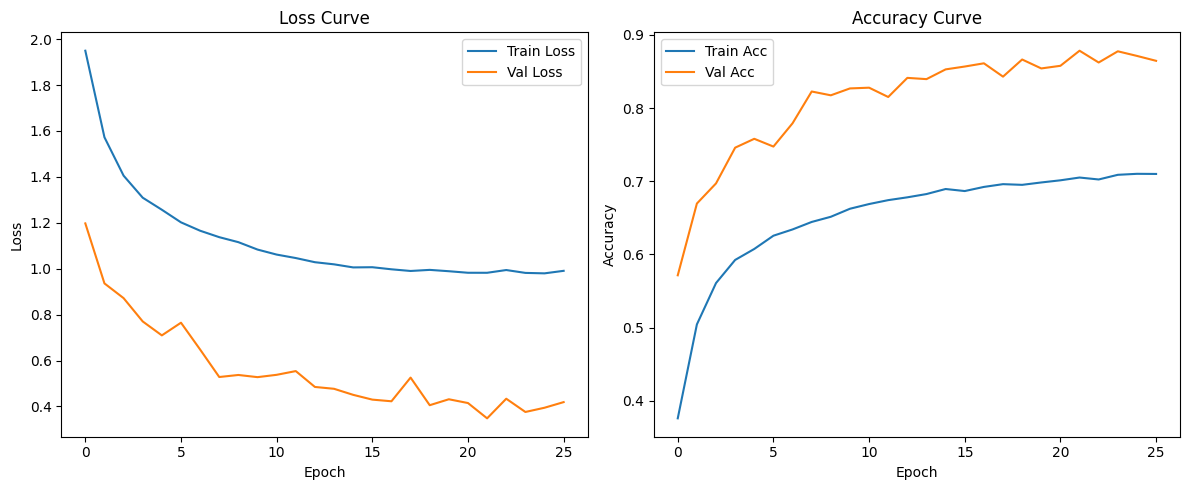

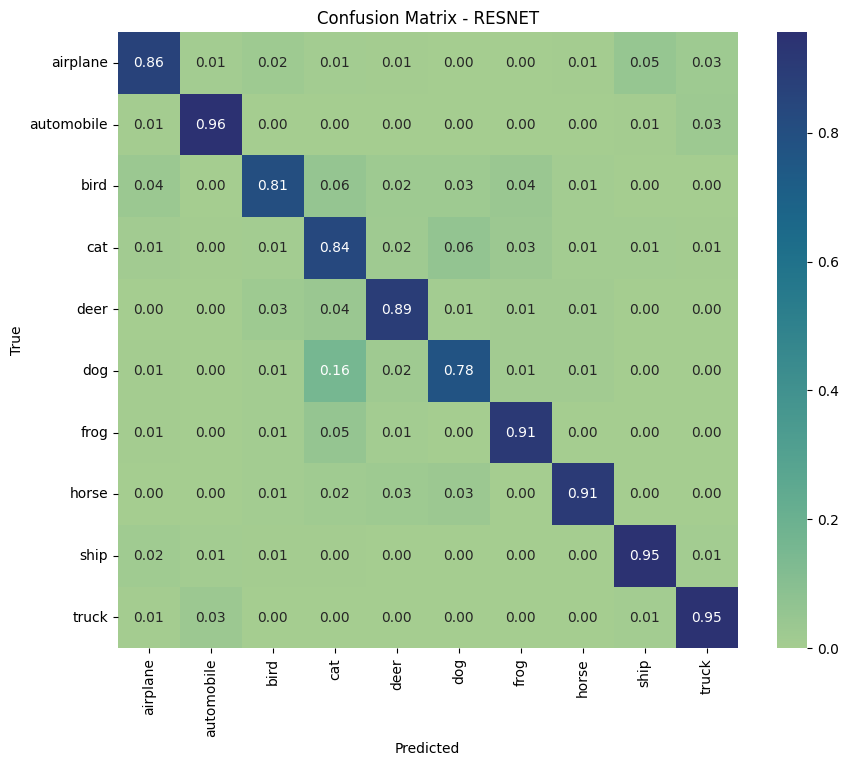

In [ ]:
check_gpu()
X_train, Y_train, X_test, Y_test = load_cifar10_binary('/kaggle/input/cifar-10-bi/cifar-10-binary/cifar-10-batches-bin')
Y_train = one_hot_encode(Y_train)
Y_test = one_hot_encode(Y_test)

model = ResNet(block_config=[2,2,2,2], num_classes=10, use_adam=True)  
loss_fn = SoftmaxWithLoss()

train_resnet(
    model,
    loss_fn,
    X_train, Y_train,
    X_val=X_test, Y_val=Y_test,
    epochs=50,
    batch=64,
    lr=0.005,
    reg_lambda=1e-3
)


In [44]:
model = ResNet()  
# load_model(model, '/kaggle/working/best_model.npz')  
